# Visualize Networkss

In [20]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
import networkx as nx
from utils.subutils.Functions import *
from utils.Segregation import *

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from fa2.forceatlas2 import ForceAtlas2

# Miscellaneous
from glob import glob
from tqdm import tqdm
import random
import time

random.seed(2)

# Create ForceAtlas2 object with desired parameters
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

In [50]:
# Load the graph
test_file = "/mnt/disk2/Data/3_Day_Graphs/starting_2021-05-03.graphml"

# Load Grap
g = gt.load_graph(test_file)
#pos = gt.fruchterman_reingold_layout(g, n_iter=50)
#g.vp['Fruchterman layout'] = pos
g.set_directed(False)
g_nx = to_networkx(g)

date = test_file.split('.')[-2].split('/')[-1]

### Testing the package

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:10<00:00, 483.52it/s]

BarnesHut Approximation  took  6.81  seconds
Repulsion forces  took  2.75  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.10  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


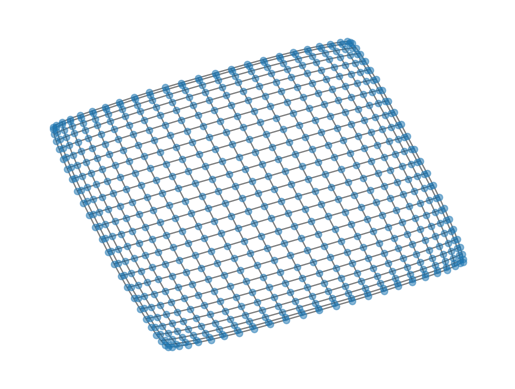

In [7]:
G = nx.grid_2d_graph(25, 25)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5000)
nx.draw_networkx(G, positions, node_size=20, with_labels=False, alpha=0.5)
plt.axis('off')
plt.show()

100%|██████████| 2000/2000 [00:02<00:00, 769.20it/s]

BarnesHut Approximation  took  1.30  seconds
Repulsion forces  took  0.85  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.27  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


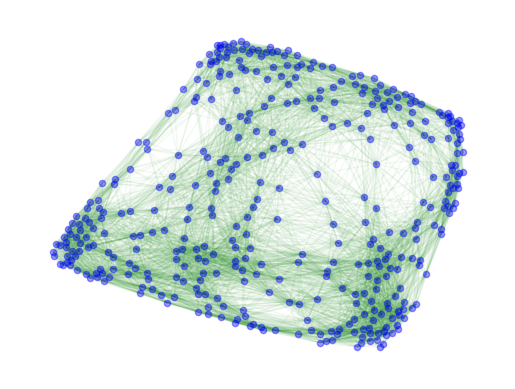

In [9]:
G = nx.random_geometric_graph(400, 0.2)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=20, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

In [10]:
# Get rid of self loops
g_nx.remove_edges_from(nx.selfloop_edges(g_nx))

# Find all connected components, sorted by size
connected_components = sorted(nx.connected_components(g_nx), key=len, reverse=True)

# Get the largest and second largest connected components
largest_cc = connected_components[0]
second_largest_cc = connected_components[1] if len(connected_components) > 1 else set()

# Combine the two components
combined_cc = largest_cc.union(second_largest_cc)

# Create a subgraph from the combined components
subgraph = g_nx.subgraph(combined_cc)
largest_cc_subgraph = g_nx.subgraph(largest_cc)

In [11]:
# Manually gather information
num_nodes = g_nx.number_of_nodes()
num_edges = g_nx.number_of_edges()
average_degree = sum(dict(g_nx.degree()).values()) / num_nodes

# Print information
print('Big Graph')
print(f"Graph has {num_nodes} nodes and {num_edges} edges.")
print(f"Average degree: {average_degree:.2f}")
print('_________________________________________________________')

# Manually gather information
num_nodes = subgraph.number_of_nodes()
num_edges = subgraph.number_of_edges()
average_degree = sum(dict(subgraph.degree()).values()) / num_nodes

# Print information
print('Largest Component Graph')
print(f"Graph has {num_nodes} nodes and {num_edges} edges.")
print(f"Average degree: {average_degree:.2f}")
print('_________________________________________________________')

# Manually gather information
num_nodes = largest_cc_subgraph.number_of_nodes()
num_edges = largest_cc_subgraph.number_of_edges()
average_degree = sum(dict(largest_cc_subgraph.degree()).values()) / num_nodes

# Print information
print('Two Largest Component Graph')
print(f"Graph has {num_nodes} nodes and {num_edges} edges.")
print(f"Average degree: {average_degree:.2f}")
print('_________________________________________________________')

Big Graph
Graph has 30645 nodes and 524153 edges.
Average degree: 34.21
_________________________________________________________
Largest Component Graph
Graph has 30503 nodes and 524128 edges.
Average degree: 34.37
_________________________________________________________
Two Largest Component Graph
Graph has 30498 nodes and 524124 edges.
Average degree: 34.37
_________________________________________________________


In [69]:
positions_df = pd.read_csv('/home/fcastrillon/Data/3_Day_Graphs/positions.csv', sep=';')
pos = {i.Id: (i.X, i.Y) for i in positions_df.itertuples()}

layout = forceatlas2.forceatlas2_networkx_layout(g_nx, pos=pos, iterations=100)

100%|██████████| 100/100 [01:52<00:00,  1.12s/it]

BarnesHut Approximation  took  35.83  seconds
Repulsion forces  took  74.12  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  1.68  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


In [64]:
pos

{1: (-312.234741, 149.899887),
 191: (723.086365, 637.329407),
 365: (954.406189, 1438.419678),
 970: (-1392.81665, 300.606598),
 1543: (-779.69165, -1285.339355)}

In [23]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
color_map_node = [color_map_dict[subgraph.nodes[node]['Political Label']] for node in subgraph]
color_edge_map = [color_map_dict[subgraph.nodes(data=True)[edge[1]]['Political Label']] for edge in list(subgraph.edges(data=True))]

# Alpha
degrees = dict(subgraph.degree())
max_degree = max(degrees.values())
alpha_values = [(degree / max_degree) for degree in degrees.values()]

# Size
node_degrees = [subgraph.degree(node) * 100 for node in subgraph.nodes()]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
node_size = list(map(lambda x: normalize(x, max_deg, min_deg), node_degrees))

In [ ]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
color_map_node = [color_map_dict[subgraph.nodes[node]['Political Label']] for node in subgraph]
color_edge_map = [color_map_dict[subgraph.nodes(data=True)[edge[1]]['Political Label']] for edge in list(subgraph.edges(data=True))]

# Alpha
degrees = dict(subgraph.degree())
max_degree = max(degrees.values())
alpha_values = [(degree / max_degree) for degree in degrees.values()]

# Size
node_degrees = [subgraph.degree(node) * 100 for node in subgraph.nodes()]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
node_size = list(map(lambda x: normalize(x, max_deg, min_deg), node_degrees))

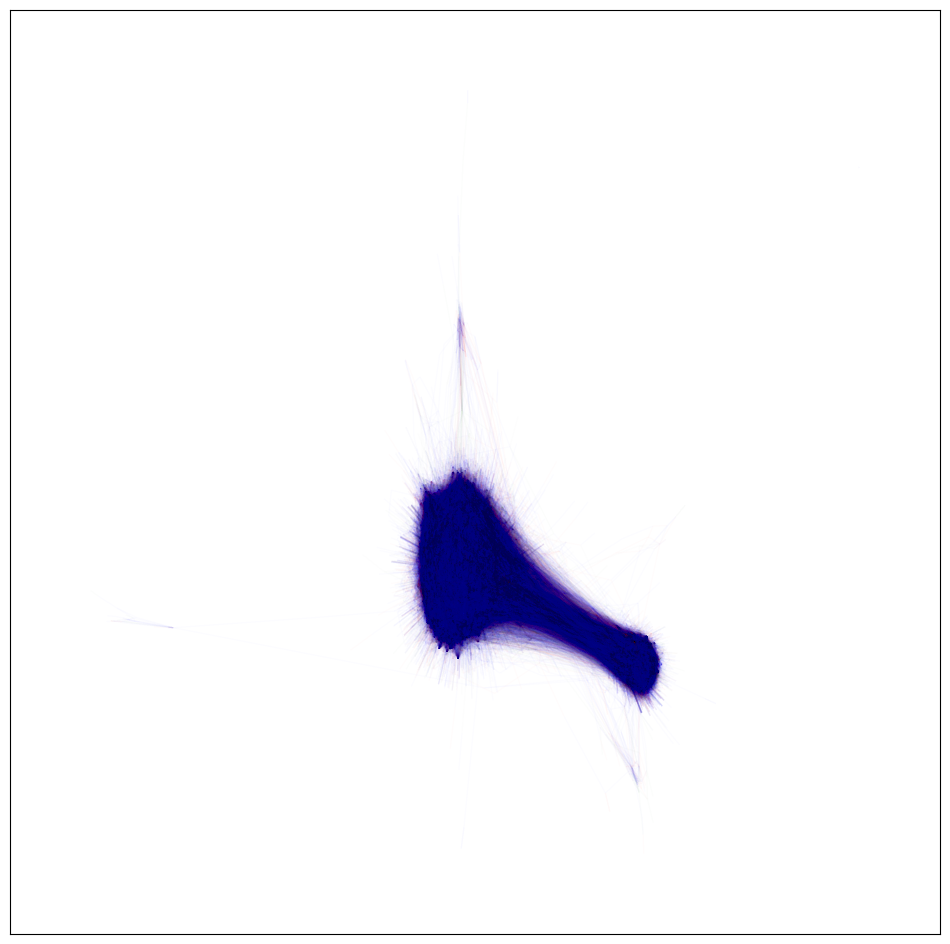

In [24]:
fig, ax = plt.subplots(figsize = (12,12))

#nx.draw_networkx_nodes(subgraph, layout, node_color = color_map_node, node_size = node_size, ax = ax, alpha = alpha_values)
nx.draw_networkx_edges(subgraph, layout, edge_color=color_edge_map, alpha = 0.01)
plt.show()

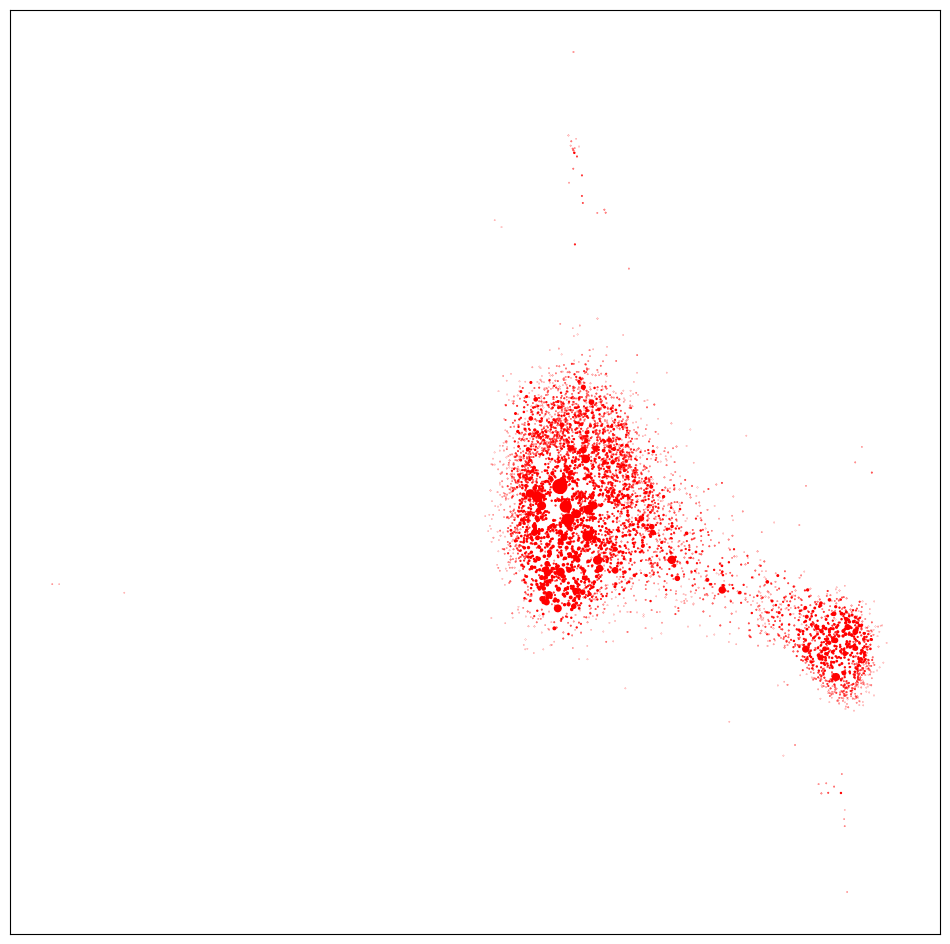

In [45]:
derecha_nodes = [node for node, attrs in subgraph.nodes(data=True) if attrs.get('Political Label') == 'Derecha']

# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
d_color_map_node = [color_map_dict[subgraph.nodes[node]['Political Label']] for node in derecha_nodes]
color_edge_map = [color_map_dict[subgraph.nodes(data=True)[edge[1]]['Political Label']] for edge in list(subgraph.edges(data=True))]

# Alpha
degrees = dict(subgraph.degree())
max_degree = max(degrees.values())
d_alpha_values = [(degree / max_degree) for node, degree in degrees.items() if node in derecha_nodes]

# Size
d_node_degrees = [subgraph.degree(node) * 100 for node in derecha_nodes]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
d_node_size = list(map(lambda x: normalize(x, max_deg, min_deg), d_node_degrees))

fig, ax = plt.subplots(figsize = (12,12))
nx.draw_networkx_nodes(subgraph, layout, nodelist=derecha_nodes, node_color = d_color_map_node, node_size = d_node_size, ax = ax)

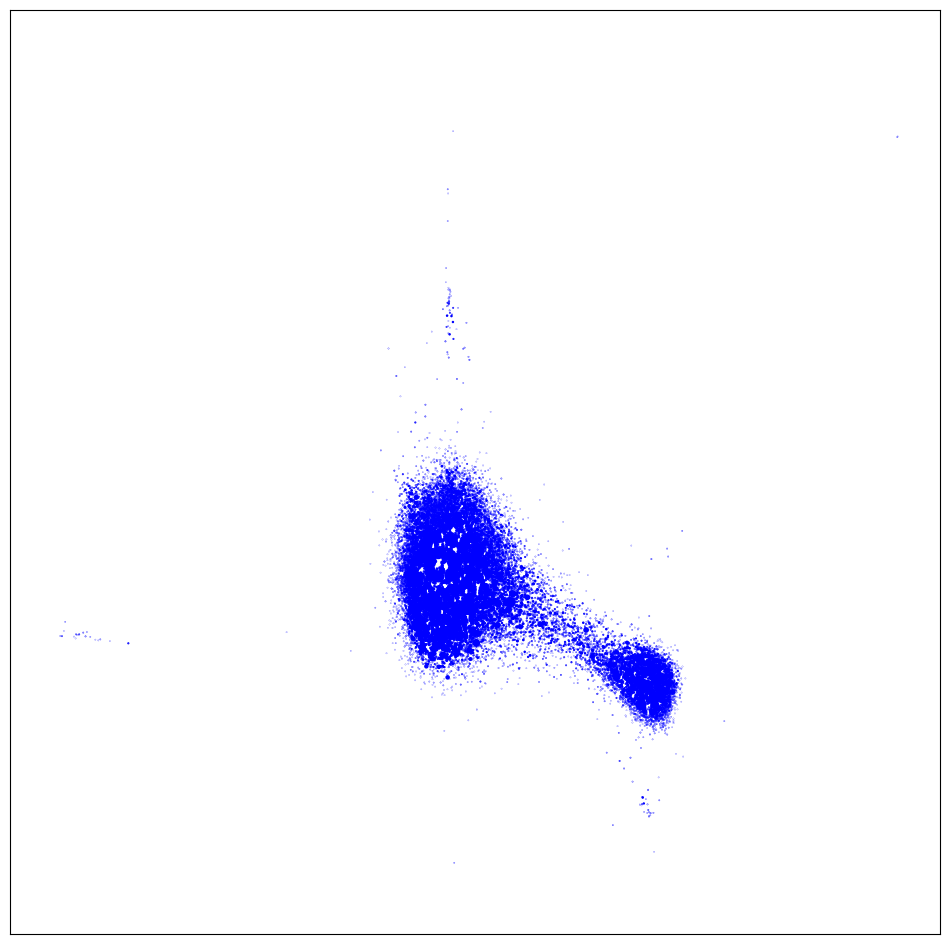

In [48]:
izquierda_nodes = [node for node, attrs in subgraph.nodes(data=True) if attrs.get('Political Label') == 'Izquierda']

# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
i_color_map_node = [color_map_dict[subgraph.nodes[node]['Political Label']] for node in izquierda_nodes]
color_edge_map = [color_map_dict[subgraph.nodes(data=True)[edge[1]]['Political Label']] for edge in list(subgraph.edges(data=True))]

# Alpha
degrees = dict(subgraph.degree())
max_degree = max(degrees.values())
i_alpha_values = [(degree / max_degree) for node, degree in degrees.items() if node in izquierda_nodes]

# Size
i_node_degrees = [subgraph.degree(node) * 100 for node in izquierda_nodes]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
i_node_size = list(map(lambda x: normalize(x, max_deg, min_deg), i_node_degrees))

fig, ax = plt.subplots(figsize = (12,12))
nx.draw_networkx_nodes(subgraph, layout, nodelist=izquierda_nodes, node_color = i_color_map_node, node_size = i_node_size, ax = ax)

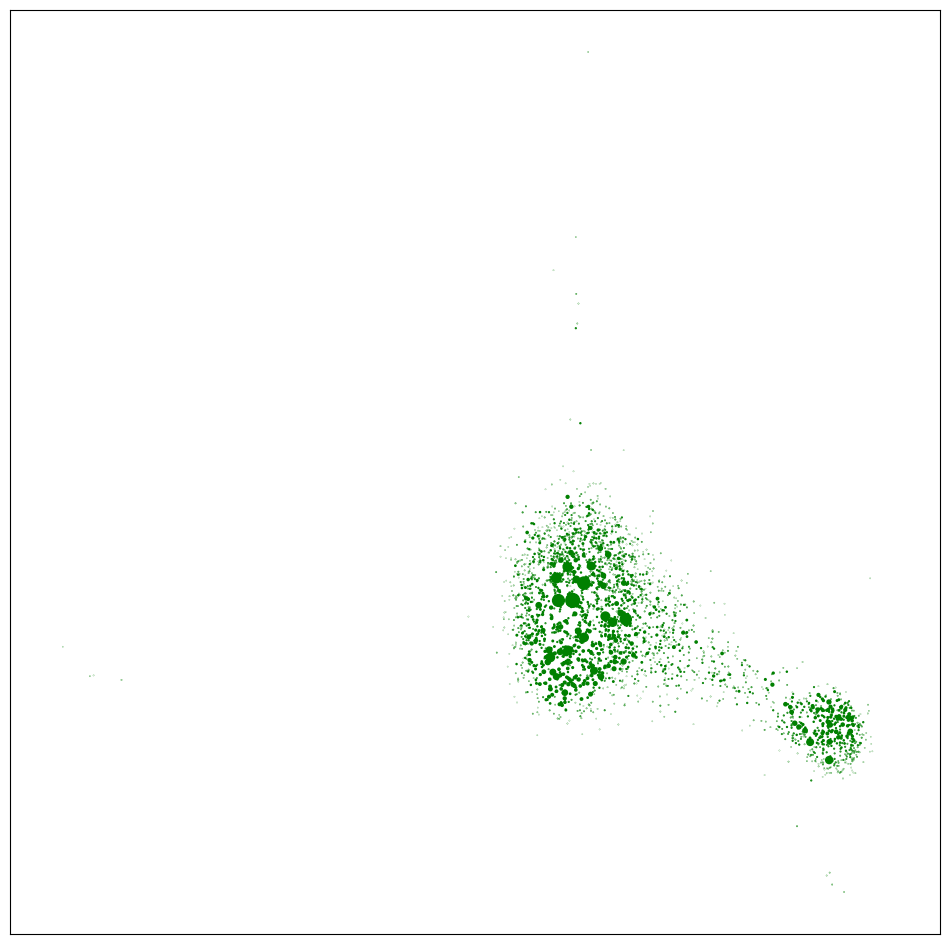

In [49]:
centro_nodes = [node for node, attrs in subgraph.nodes(data=True) if attrs.get('Political Label') == 'Centro']

# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
c_color_map_node = [color_map_dict[subgraph.nodes[node]['Political Label']] for node in centro_nodes]
color_edge_map = [color_map_dict[subgraph.nodes(data=True)[edge[1]]['Political Label']] for edge in list(subgraph.edges(data=True))]

# Alpha
degrees = dict(subgraph.degree())
max_degree = max(degrees.values())
c_alpha_values = [(degree / max_degree) for node, degree in degrees.items() if node in centro_nodes]

# Size
c_node_degrees = [subgraph.degree(node) * 100 for node in centro_nodes]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
c_node_size = list(map(lambda x: normalize(x, max_deg, min_deg), c_node_degrees))

fig, ax = plt.subplots(figsize = (12,12))
nx.draw_networkx_nodes(subgraph, layout, nodelist=centro_nodes, node_color = c_color_map_node, node_size = c_node_size, ax = ax)

# Gephis Force Atlas 2

/mnt/disk2/anaconda3/envs/gt_global/lib/python3.11/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


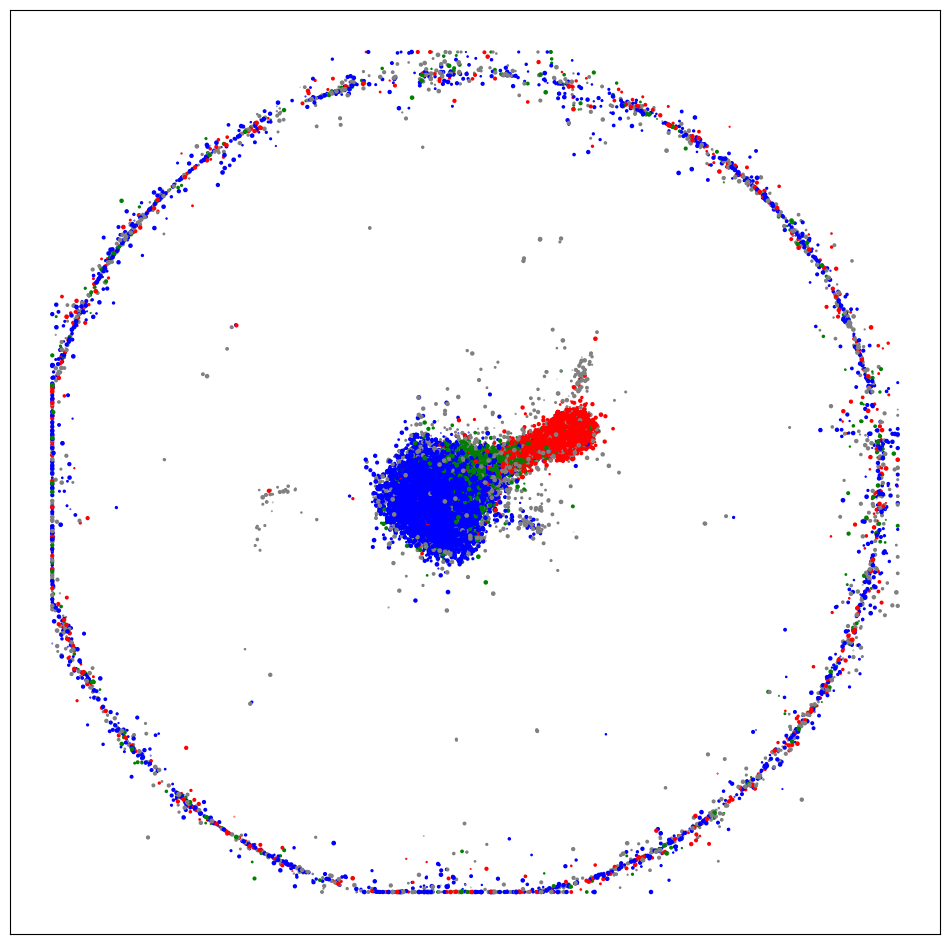

In [72]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
t_color_map_node = [color_map_dict[g_nx.nodes[node]['Political Label']] for node in g_nx.nodes]
color_edge_map = [color_map_dict[g_nx.nodes(data=True)[edge[1]]['Political Label']] for edge in list(g_nx.edges(data=True))]

# Alpha
degrees = dict(g_nx.degree())
max_degree = max(degrees.values())
t_alpha_values = [(degree / max_degree) for node, degree in degrees.items() if node in g_nx.nodes]

# Size
t_node_degrees = [g_nx.degree(node) * 100 for node in g_nx.nodes]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
t_node_size = list(map(lambda x: normalize(x, max_deg, min_deg), g_nx.nodes))

fig, ax = plt.subplots(figsize = (12,12))
nx.draw_networkx_nodes(g_nx, pos, node_color = t_color_map_node, node_size = t_node_size, ax = ax)

# NetworkX Force Atlas 2

/mnt/disk2/anaconda3/envs/gt_global/lib/python3.11/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


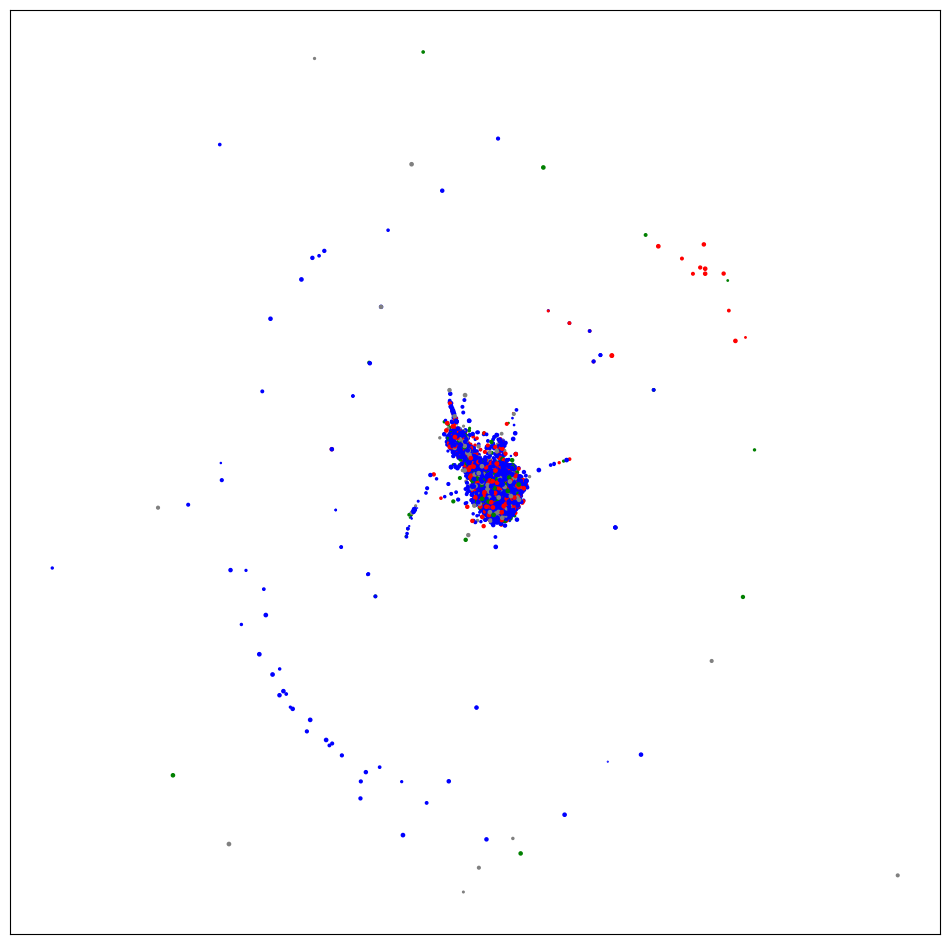

In [70]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
t_color_map_node = [color_map_dict[g_nx.nodes[node]['Political Label']] for node in g_nx.nodes]
color_edge_map = [color_map_dict[g_nx.nodes(data=True)[edge[1]]['Political Label']] for edge in list(g_nx.edges(data=True))]

# Alpha
degrees = dict(g_nx.degree())
max_degree = max(degrees.values())
t_alpha_values = [(degree / max_degree) for node, degree in degrees.items() if node in g_nx.nodes]

# Size
t_node_degrees = [g_nx.degree(node) * 100 for node in g_nx.nodes]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
t_node_size = list(map(lambda x: normalize(x, max_deg, min_deg), g_nx.nodes))

fig, ax = plt.subplots(figsize = (12,12))
nx.draw_networkx_nodes(g_nx, layout, node_color = t_color_map_node, node_size = t_node_size, ax = ax)